In [1]:
from importlib import reload
import argparse
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import math

import torchvision.transforms as transforms
from torchvision.utils import save_image

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch

import gan

cuda = torch.cuda.is_available()

print("Cuda: " + str(cuda))
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

Cuda: True
Cuda: True


In [2]:
latent_dim = 2
loaded_gen = gan.load_model("good_generator_81", layer_width=400).eval()

for param in loaded_gen.parameters():
    param.requires_grad = False
    
grid_length = 9

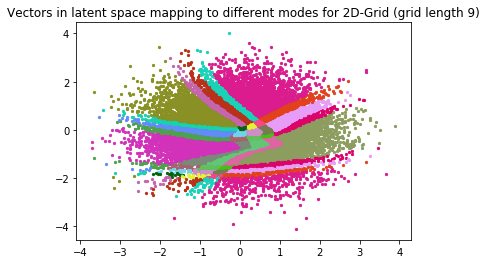

In [3]:
gan.visualize_latent_space(loaded_gen, latent_dim=latent_dim, grid_length=grid_length)